In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [11]:
df["target"] = df.card.apply(lambda x: 1 if x == "yes" else 0)

In [12]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12,1
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13,1
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5,1
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7,1
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5,1


In [13]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train_full = df_train_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train_full = df_train_full['target'].values
y_train = df_train['target'].values
y_val = df_val['target'].values
y_test = df_test['target'].values


ROC AUC could also be used to evaluate feature importance of numerical variables.<br>
If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['expenditure']) <br>
AUC can go below 0.5 if the variable is negatively correlated with the target varialble. <br>You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.


In [17]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [24]:
df_train.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
target           int64
dtype: object

#### Question 1

In [39]:
numeric = ['reports', 'age', 'income', 'share', 'dependents', 'expenditure', 'months', 'active']

In [51]:
for idx in numeric:
    auc = roc_auc_score(y_train, df_train[idx])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[idx])
    print(f'{idx.title()} AUC score: {auc:.3f}')

Reports AUC score: 0.717
Age AUC score: 0.524
Income AUC score: 0.591
Share AUC score: 0.989
Dependents AUC score: 0.533
Expenditure AUC score: 0.991
Months AUC score: 0.529
Active AUC score: 0.604


#### Question 2

In [54]:
variables = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [55]:
train_dict = df_train[variables].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [56]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [57]:
val_dict = df_val[variables].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]

In [58]:
roc_auc_score(y_val, y_pred)

0.995171242063847

#### Question 3

In [61]:
scores = []

In [64]:
thresholds = np.linspace(0, 1, 101)

In [65]:
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred <= t) & (y_val == 1)).sum()
    tn = ((y_pred <= t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

In [66]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

In [67]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,211,53,0,0
10,0.1,210,17,1,36
20,0.2,207,5,4,48
30,0.3,205,5,6,48
40,0.4,205,1,6,52
50,0.5,204,1,7,52
60,0.6,204,1,7,52
70,0.7,204,1,7,52
80,0.8,204,1,7,52
90,0.9,204,0,7,53


In [68]:
df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)


In [69]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,0,19,0.861224,1.000000
2,0.02,211,31,0,22,0.871901,1.000000
3,0.03,211,24,0,29,0.897872,1.000000
4,0.04,211,22,0,31,0.905579,1.000000
...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,1.000000,0.966825
97,0.97,203,0,8,53,1.000000,0.962085
98,0.98,203,0,8,53,1.000000,0.962085
99,0.99,202,0,9,53,1.000000,0.957346


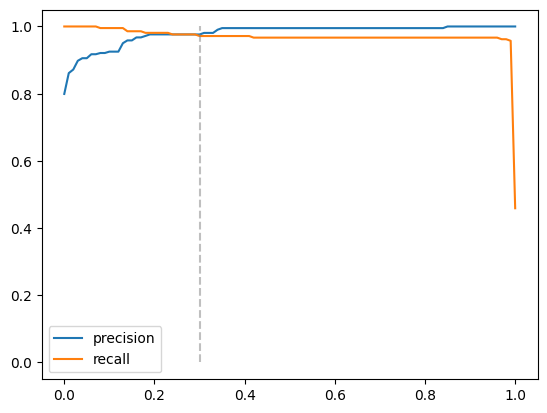

In [84]:
plt.plot(df_scores.threshold, df_scores.precision, label="precision")
plt.plot(df_scores.threshold, df_scores.recall, label="recall")
plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


#### Question 4

In [85]:
df_scores['f1'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

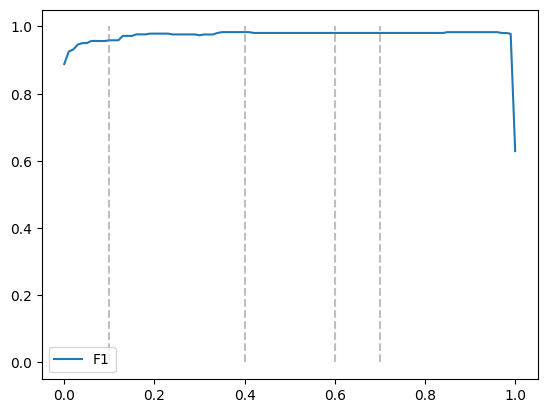

In [88]:
plt.plot(df_scores.threshold, df_scores.f1, label="F1")
plt.vlines(0.1, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.vlines(0.4, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.vlines(0.6, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.vlines(0.7, 0, 1, color='grey', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [90]:
df_scores.f1.max()

0.9832134292565947

In [91]:
df_scores[df_scores["f1"] == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,precision,recall,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213


#### Question 5

In [132]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [133]:
def train(df, y):
    cat = df[variables].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)
    
    return dv, model

In [141]:
def predict(df, dv, model):
    cat = df[variables].to_dict(orient='records')
    
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred


In [142]:
aucs = []

In [143]:
for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    y_train = df_train.target.values
    y_val = df_val.target.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

In [144]:
print(f'AUC std: ±{np.std(aucs):.3f}')

AUC std: ±0.003


In [145]:
def train(df, y, C):
    cat = df[variables].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)
    
    return dv, model

In [146]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [148]:
for C in [0.01, 0.1, 1, 10]:
    aucs = []
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
    print(f'C= {C}, AUC mean = {np.mean(aucs):.3f}, AUC std = {np.std(aucs):.3f}')

C= 0.01, AUC mean = 0.992, AUC std = 0.006
C= 0.1, AUC mean = 0.995, AUC std = 0.004
C= 1, AUC mean = 0.996, AUC std = 0.003
C= 10, AUC mean = 0.996, AUC std = 0.003
